In [1]:
!pip install scanpy anndata numpy pandas scipy statsmodels scikit-learn pyro-ppl torch --quiet

In [1]:
import scanpy as sc
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/nested-chinese-restaurant-process/data/new_annotations.h5ad")

In [112]:
import torch
X = torch.tensor(adata[adata.obs["Cell.Subtype"].eq("Astro")].X.todense()).to("cuda")
X = X[:, ((X > 0).float().mean(axis=0) > 0.30)]
X.shape[1]

495

# Description of the sampling method

1. Setup a tree structure
- The intial node will be the full dataset, we fit a dirichlet multinomial distribution to the proposed dataset, and shove all the nodes into some index set. 

2. Begin the sampling procedure. 
- Given a random permutation of the nodes, we then sample each one sequentially. We take that node, and then ask whether to make a new node, or add it to a child that already exists. 

    - In the case that the current node has no children, this is trivial, we simply create a new node, and compute a new alpha for that node, use the code in `propose_new_alpha`

    - If we have a set of children, then we do the following:
        - calculate the log probabilities for each of the children, then compute the following update probabilities
            - Existing node k: $\log P_k = \log(N_k) - \log(\alpha_n + \sum_j N_j) + \log P(x_i | \text{child } k)$
            - New node: $\log P_{new} = \log(\alpha_n) - \log(\alpha_n + \sum_j N_j) + \log P(x_i | \text{new child})$
                - The probability of the new node is determined by some proposed alpha, which is a smoothing between the parent alpha and our new sample, which we just estimate using the following:
                    - `alpha_new = alpha_parent * gamma + (1-gamma) * (x_0 + 1e-3)`
        - We choose from the possible choices using a multinomial draw from the calculated probabilities. 
        - We continue this until we end up at a node with no children.

3. Once we reach the end, we start from the top, but as we sample, we remove the index from the tree it was previously a part of. This will involve:
- For nodes with >3 samples prior to removal, we remove the prior sample, and then refit the distribution using the remaining indices via minka's method
- For nodes with 2 samples prior to removal, we remove the prior sample, and then refit using `propose_new_alpha`, but alpha_0 in this case will be the node's current alpha, instead of the parent alpha as it usually is. 
- If there was only one sample in the node, we remove the node. 

Continue until you're happy. 

In [ ]:
def remove_index_from_tree(node, i, data_counts, gamma=0.99, epsilon=1e-3, root_node=None):
    """
    Remove index `i` from the tree rooted at `node`, and update node parameters or prune as needed.
    """

    # Search for the node that contains index i
    target_node = find_node_containing_index(node, i)
    if target_node is None or target_node is root_node:
        return  # Index not found or in root (never remove from root)

    # Remove the index
    target_node.remove_index(i)

    # Decide what to do based on new size of the node
    num_remaining = len(target_node.indices)

    if num_remaining >= 3:
        # Enough data to refit
        subset_counts = data_counts[list(target_node.indices)]
        target_node.alpha = minka_estimate_alpha(subset_counts)

    elif num_remaining == 2:
        # Small update
        target_node.alpha = propose_new_alpha(target_node.alpha, data_counts[i], gamma=gamma, epsilon=epsilon)

    elif num_remaining == 0:
        # Node is now empty: prune it
        parent = target_node.parent
        if parent:
            parent.remove_child(target_node)

    # (Optional) Remove further empty nodes recursively upward
    prune_empty_ancestors(target_node)

def find_node_containing_index(node, i):
    """
    Recursively find the node containing index i.
    """
    if i in node.indices:
        return node
    for child in node.children:
        found = find_node_containing_index(child, i)
        if found:
            return found
    return None

def prune_empty_ancestors(node):
    """
    Prune empty ancestors recursively.
    """
    current = node
    while current.parent is not None and len(current.indices) == 0 and len(current.children) == 0:
        parent = current.parent
        parent.remove_child(current)
        current = parent

In [113]:
import torch
from pyro.distributions import DirichletMultinomial
from torch.special import digamma
import random
from tqdm import tqdm

class TreeNode:
    def __init__(self, indices, alpha, parent=None, vocab_size=None):
        self.indices = set(indices)  # set of data indices in node
        self.alpha = alpha  # torch tensor, Dirichlet concentration parameter (size vocab_size)
        self.parent = parent
        self.children = []
        self.vocab_size = vocab_size

    def count(self, data_counts):
        # Sum of counts over indices in this node
        return data_counts[list(self.indices)].sum(dim=0)

    def log_likelihood(self, x_i):
        # Log prob of a single data point under this node's Dirichlet-Multinomial
        dist = DirichletMultinomial(self.alpha, total_count = x_i.sum())
        return dist.log_prob(x_i)

    def add_child(self, child_node):
        self.children.append(child_node)
        child_node.parent = self

    def remove_child(self, child_node):
        self.children.remove(child_node)
        child_node.parent = None

    def remove_index(self, i):
        self.indices.remove(i)

    def add_index(self, i):
        self.indices.add(i)


def propose_new_alpha(alpha_parent, x_i, gamma=0.9, epsilon=1e-3):
    return gamma * alpha_parent + (1 - gamma) * (x_i.float() + epsilon)

def minka_estimate_alpha(X, max_iter=1000, tol=1e-2, eps=1e-10, device='cuda'):
    """
    Minka-style fixed-point update for Dirichlet-Multinomial fitting.

    Args:
        X: (N x K) torch tensor of count data
        Returns: (K,) torch tensor of Dirichlet parameters alpha
    """
    X = X.to(device)
    N, K = X.shape
    alpha = torch.ones(K, device=device)

    for _ in range(max_iter):
        alpha_old = alpha.clone()
        alpha_0 = alpha.sum()
        digamma_alpha_k = digamma(alpha)
        digamma_alpha_0 = digamma(alpha_0)

        numerator = torch.sum(digamma(X + alpha) - digamma_alpha_k, dim=0)
        denom = torch.sum(digamma(X.sum(dim=1, keepdim=True) + alpha_0) - digamma_alpha_0)

        alpha = alpha * numerator / denom
        alpha = torch.clamp(alpha, min=eps)

        if torch.max(torch.abs(alpha - alpha_old)) < tol:
            break

    return alpha

def sample_child_node_or_new(parent_node, x_i, alpha_n, data_counts, gamma=0.9, epsilon=1e-3):
    """Given a parent node and data point x_i, sample which child to assign x_i to or create new."""

    N_js = torch.tensor([len(child.indices) for child in parent_node.children], dtype=torch.float)
    sum_N_js = N_js.sum()
    log_probs = []

    # Existing children
    for child in parent_node.children:
        log_p_k = torch.log(torch.tensor(len(child.indices), dtype=torch.float32)) - torch.log(torch.tensor(alpha_n + sum_N_js, dtype=torch.float32)) + child.log_likelihood(x_i)
        log_probs.append(log_p_k)

    # New child
    alpha_new = propose_new_alpha(parent_node.alpha, x_i, gamma=gamma, epsilon=epsilon)
    new_node = TreeNode(indices=set(), alpha=alpha_new, vocab_size=parent_node.vocab_size)
    log_p_new = torch.log(torch.tensor(alpha_n, dtype=torch.float32)) - torch.log(torch.tensor(alpha_n + sum_N_js, dtype=torch.float32)) + new_node.log_likelihood(x_i)
    log_probs.append(log_p_new)

    log_probs_tensor = torch.stack(log_probs)
    probs = torch.softmax(log_probs_tensor, dim=0)
    choice = torch.multinomial(probs, 1).item()

    if choice == len(parent_node.children):
        # Create new child node
        parent_node.add_child(new_node)
        return new_node
    else:
        return parent_node.children[choice]

def prune_tree(node, min_size):
    # Copy list to avoid modification during iteration
    children_copy = node.children[:]
    
    for child in children_copy:
        prune_tree(child, min_size)  # recurse first
        
        # If child is too small, remove it
        if len(child.indices) < min_size:
            node.remove_child(child)
            # Optionally, you might want to reassign child.indices to parent or handle them somehow
            # For example, add back to parent node indices if appropriate:
            # node.indices.update(child.indices)

def gibbs_sample(data_counts, root_node, alpha_n, gamma=0.9, epsilon=1e-3, n_iters=10):
    """
    data_counts: tensor shape (N_samples, V)
    root_node: initial root TreeNode with all indices assigned
    alpha_n: scalar CRP concentration parameter
    """

    N = data_counts.shape[0]
    all_indices = list(range(N))

    for it in range(n_iters):
        random.shuffle(all_indices)
        for i in tqdm(all_indices):
            # Remove i from tree
            remove_index_from_tree(root_node, i, data_counts, gamma=gamma, epsilon=epsilon, root_node=root_node)

            # Sample new assignment
            current_node = root_node
            while True:
                if len(current_node.children) == 0:
                    # Create new node
                    new_alpha = propose_new_alpha(current_node.alpha, data_counts[i], gamma=gamma, epsilon=epsilon)
                    new_node = TreeNode(indices={i}, alpha=new_alpha, parent=current_node, vocab_size=current_node.vocab_size)
                    current_node.add_child(new_node)
                    break
                else:
                    next_node = sample_child_node_or_new(current_node, data_counts[i], alpha_n, data_counts, gamma=gamma, epsilon=epsilon)
                    if len(next_node.children) == 0:
                        next_node.add_index(i)
                        break
                    else:
                        current_node = next_node
        prune_tree(root_node, min_size=data_counts.shape[0]//100)
    return root_node


def remove_index_from_tree(node, i, data_counts, gamma=0.99, epsilon=1e-3, root_node=None):
    """
    Recursively remove index i from any node it's found in the tree rooted at `node`.
    Update alpha or prune the node if needed.
    """
    # Recurse through children first
    for child in list(node.children):  # use list() to avoid modification during iteration
        remove_index_from_tree(child, i, data_counts, gamma, epsilon, root_node)

    # If index is in this node
    if i in node.indices:
        if node is root_node:
            # Never remove from root node
            return

        if len(node.indices) > 3:
            node.remove_index(i)
            subset_counts = data_counts[list(node.indices)]
            node.alpha = minka_estimate_alpha(subset_counts)

        elif len(node.indices) == 2:
            node.remove_index(i)
            node.alpha = propose_new_alpha(node.alpha, data_counts[i], gamma=gamma, epsilon=epsilon)

        elif len(node.indices) == 1:
            node.remove_index(i)
            # Remove node entirely
            if node.parent is not None:
                node.parent.remove_child(node)


In [115]:
alpha_root = minka_estimate_alpha(X)
root_node = TreeNode(indices=set(range(X.shape[0])), alpha=alpha_root, vocab_size=X.shape[1])

# Some nice notes

Since we should be learning the proper structure over time, the sampling actually gets quicker as we go along, since we create less branches over time. Which is nice!

In [116]:
root_node = gibbs_sample(
    X, 
    root_node, 
    alpha_n=.1, 
    gamma=0.999, 
    epsilon=1e-3, 
    n_iters=5, 
)

  0%|          | 0/7424 [00:00<?, ?it/s]/tmp/ipykernel_3222839/2884258250.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_p_k = torch.log(torch.tensor(len(child.indices), dtype=torch.float32)) - torch.log(torch.tensor(alpha_n + sum_N_js, dtype=torch.float32)) + child.log_likelihood(x_i)
/tmp/ipykernel_3222839/2884258250.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_p_new = torch.log(torch.tensor(alpha_n, dtype=torch.float32)) - torch.log(torch.tensor(alpha_n + sum_N_js, dtype=torch.float32)) + new_node.log_likelihood(x_i)
 35%|███▌      | 2623/7424 [01:59<03:39, 21.91it/s]


KeyboardInterrupt: 

# Current Issues. 

- Too Much Splitting, or something else...
    - By the second layer, we lose everything, so it's clearly not working...
- SLOW
    - In Blei's original paper, each paper took 1ms, and here every paper takes 70ms? Python is slow but it shouldn't be that slow...


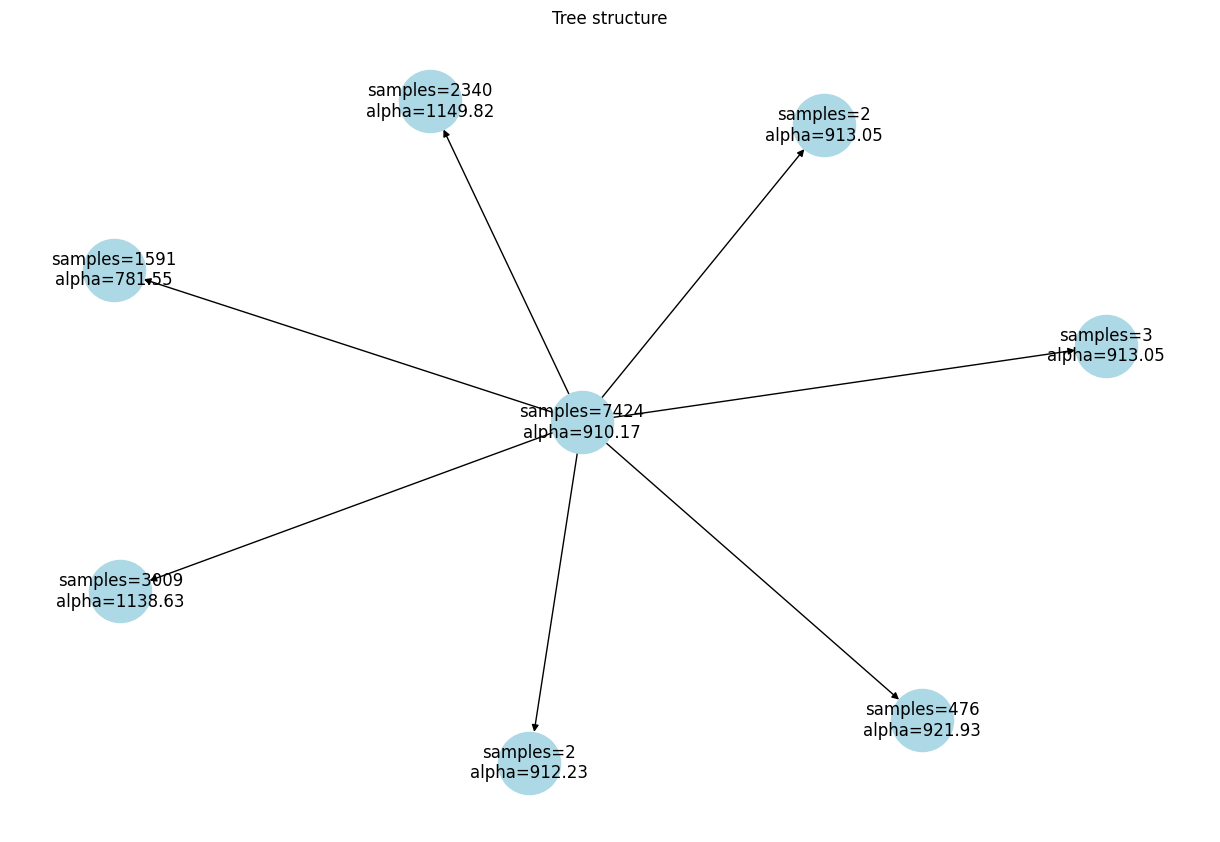

In [117]:
import networkx as nx
import matplotlib.pyplot as plt

def build_nx_graph(node, graph=None, parent=None):
    if graph is None:
        graph = nx.DiGraph()
    graph.add_node(id(node), label=f"samples={len(node.indices)}\nalpha={node.alpha.sum().item():.2f}")
    if parent is not None:
        graph.add_edge(id(parent), id(node))
    for child in node.children:
        build_nx_graph(child, graph, node)
    return graph

def plot_tree(root_node):
    G = build_nx_graph(root_node)
    labels = nx.get_node_attributes(G, 'label')
    pos = nx.spring_layout(G)  # or nx.nx_agraph.graphviz_layout(G, prog='dot') if pygraphviz is installed
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, arrows=True, node_size=2000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels)
    plt.title("Tree structure")
    plt.show()

# Usage:
plot_tree(root_node)
